# Тестирование FC-декодера

В этом ноутбуке представлены эксперименты с декодером, который состоит из `Linear->BN->ReLU` слоёв.
Ниже перечислены особенности сети и процесса обучения
* Описание класса `Decoder` и его частей лежит в файле `decoder.py`
* Сеть восстанавливает изображения из сжатого векторного представления, которое было получено от сети `facenet`. Изначально эти векторные представления обучались не для восстановления, а классфикации изображений. Но оказалось, что из них можно восстановить сносные изображения. Результат не восхитительный, но всё же менее размытый, чем у свёрточного декодера. В качестве альтернативы можно было бы использовать не готовые эмбединги от `facenet`, а построить свой автоэнкодер, но это вынуждает нас для решения задачи комбинации лиц держать в памяти загруженный энкодер (для нового лица) и декодер (для генерации смеси лиц), а это большие затраты памяти, если использовать FC-слои. Поэтому остановились только на декодере.
* Сеть состоит из нескольких полносвязных слоёв, на выходе - сигмоида, чтобы привести значения к рангу от 0 до 1.
* Для обучения использовался оптмизатор `Adam`, функция потерь `binary_cross_entropy` (обучение в файле `train_decoder.py` или `train_decoder.ipynb`)
* Предобученная модель содержится в файле `decoder_model`, откуда она и загружается в данном ноутбуке.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import imageio
# импортировать именно так
from decoder import Decoder, LinearBnRelu

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
decoder = Decoder(128, 160 * 160 * 3)
decoder = torch.load('decoder_model')
_ = decoder.train(False)

C:\Users\Uchayder\Anaconda3\lib\site-packages\torch\serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
EMB_COUNT = 202599
EMB_SIZE = 128
embeddings = np.ndarray(shape=(EMB_COUNT,EMB_SIZE))

with open('embeddings_float.txt') as f:
    for i, line in enumerate(f):
        embeddings[i, :] = np.array(list(map(np.float64, line.strip()[4:].split())))

## Восстанавливаем лица

In [19]:
np.random.seed(136781)
TEST_SIZE = 6
# используем именно эти картинки, чтобы можно было сравнить 
# качество со свёрточным декодером на одинаковых картинках
# test_emb_ids = np.array([15795,   860,  5390, 11964, 11284,  6265]) 
test_emb_ids = np.random.choice(range(EMB_COUNT), TEST_SIZE, replace=False)
test_embs = embeddings[test_emb_ids]

test_imgs = np.zeros(shape=(TEST_SIZE, 160, 160, 3))
for i, img_id in enumerate(test_emb_ids):
    img_path = 'C:/Users/Uchayder/Pictures/img_align_celeba_160/{0:06d}.jpg'.format(img_id + 1)
    test_imgs[i] = np.array(imageio.imread(img_path) / 255)

In [20]:
decoded_imgs = decoder(Variable(torch.FloatTensor(test_embs)))

bce_values = []
for i in range(TEST_SIZE):
    bce_values.append(
        F.binary_cross_entropy(
            decoded_imgs[i:i+1], 
            Variable(torch.FloatTensor(test_imgs[i:i+1].reshape(1, -1)))).cpu().data[0]
    )
decoded_imgs = decoded_imgs.data.numpy().reshape(TEST_SIZE, 160, 160, 3)

cross_entropy: 0.59588134	0.56301433	0.56159031	0.68001926	0.64100039	0.62183189


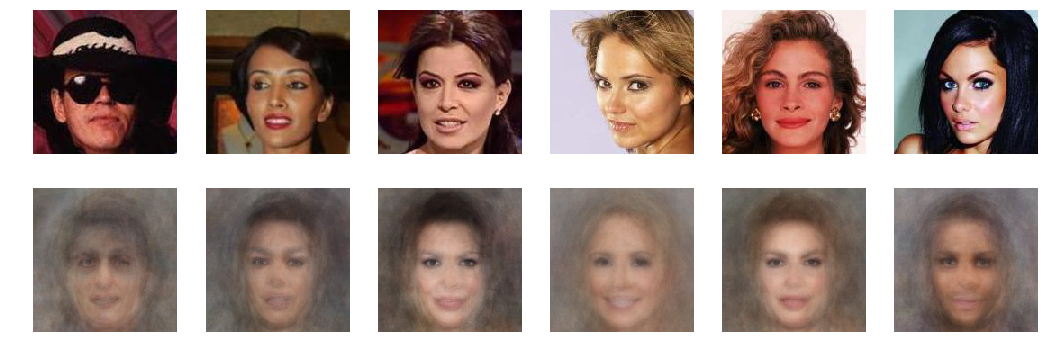

In [21]:
IMG_SIZE = 3
f = plt.subplots(2, TEST_SIZE, figsize=(IMG_SIZE * TEST_SIZE, IMG_SIZE * 2))
for i in range(TEST_SIZE):
    plt.subplot(2, TEST_SIZE, i + 1)
    plt.imshow(test_imgs[i])
    plt.axis('off')
    plt.subplot(2, TEST_SIZE, i + TEST_SIZE + 1)
    plt.imshow(decoded_imgs[i])
    plt.axis('off')
    
bce_str = ['{:.8f}'.format(i) for i in bce_values]
print('cross_entropy:', '\t'.join(bce_str))

## Смешиваем лица
Для генерации лиц, которые похожи одновременно на два исходных лица, возьмём их эмбеддинги от `facenet`, посчитаем их среднее и пропустим дальше в `decoder`. Результат показан ниже, где в матрице на пересечении строки и столбца стоит лицо, восстановленное из среднего вектора двух исходных изображений.

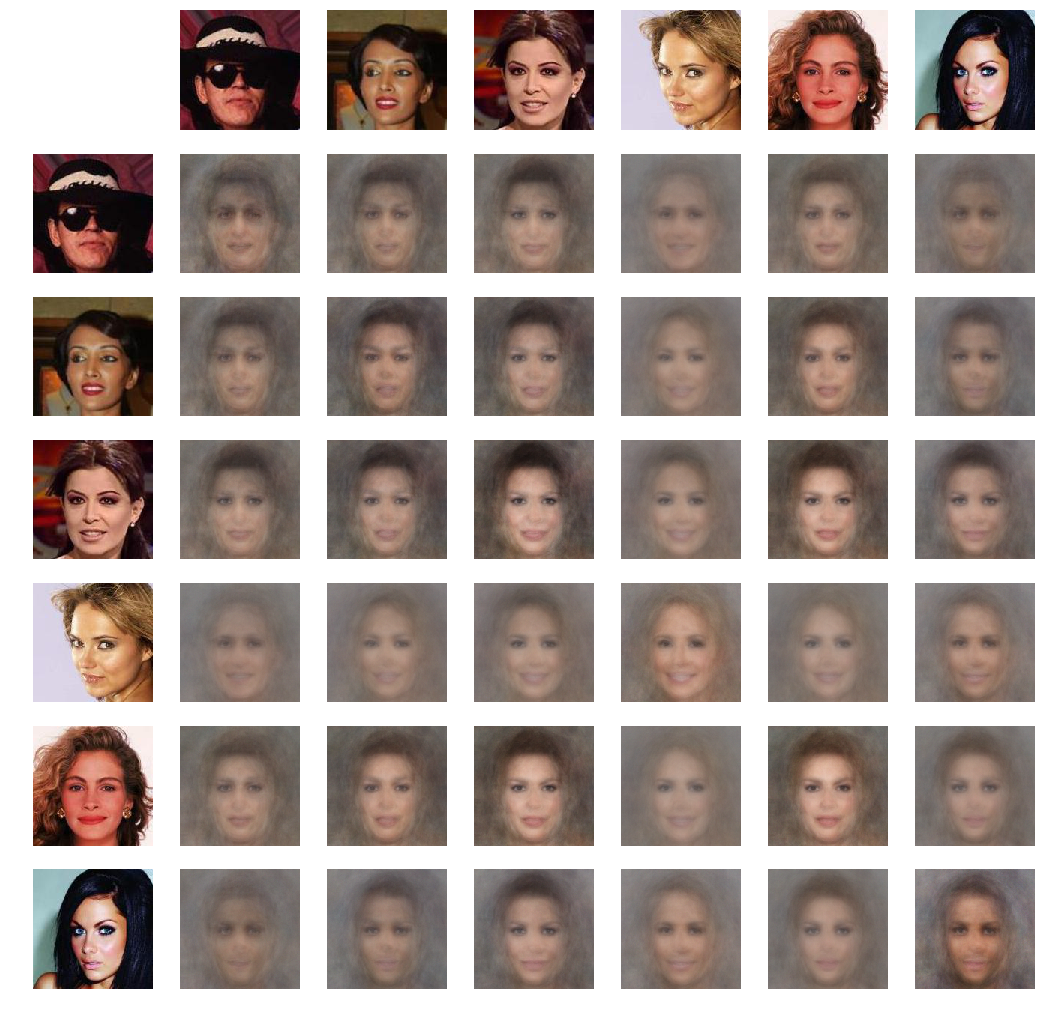

In [22]:
embs_mixed = np.zeros(shape=(TEST_SIZE ** 2, 128))

idx = 0
for i in range(TEST_SIZE):
    for j in range(TEST_SIZE):
        embs_mixed[idx] = (test_embs[i] + test_embs[j]) / 2
        idx += 1
decoded_imgs_mixed = decoder(Variable(torch.FloatTensor(embs_mixed))).data.numpy().reshape(TEST_SIZE ** 2, 160, 160, 3)

n_rows = TEST_SIZE + 1
n_cols = TEST_SIZE + 1

f = plt.subplots(n_rows, n_cols, figsize=(IMG_SIZE * TEST_SIZE, IMG_SIZE * TEST_SIZE))
for i in range(TEST_SIZE):
    plt.subplot(n_rows, n_cols, i + 2)
    plt.imshow(test_imgs[i])
    plt.axis('off')

    plt.subplot(n_rows, n_cols, n_cols * (i + 1) + 1)
    plt.imshow(test_imgs[i])
    plt.axis('off')
    
for i in range(TEST_SIZE ** 2):    
    plt.subplot(n_rows, n_cols, i + 9 + (i // 6))
    plt.imshow(decoded_imgs_mixed[i])
    plt.axis('off')
    
plt.subplot(n_rows, n_cols, 1)
_ = plt.axis('off')